In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil

root_dir = "drive/MyDrive/NewLungData"

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np

# Define data directory
data_dir = "drive/MyDrive/NewLungData"

# Define mean and standard deviation for normalization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Define image size
image_size = (256, 256)

# Define batch size
batch_size = 32

# Define data generators for train, validation, and test sets
train_datagen = ImageDataGenerator(
    rescale=1./255
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, 'val'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 5641 images belonging to 2 classes.
Found 1297 images belonging to 2 classes.
Found 1622 images belonging to 2 classes.


In [ ]:
# Load pre-trained InceptionV3 model
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(299, 299, 3))


87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
# Freeze convolutional base to prevent weights are being updated during training process
base_model.trainable = False

In [ ]:
# Base model architecture
base_model.summary()

In [ ]:
# Add custom classification layers
dropout_rate = 0.5
num_classes = 2

# Define the fully connected layers
classifier = tf.keras.Sequential([
    # Use GlobalAveragePooling2D instead of Flatten
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Concatenate the pre-trained convolutional base with the new classifier
model = tf.keras.Sequential([base_model, classifier])


In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate,weight_decay=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 10
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(train_generator, epochs=initial_epochs, validation_data=val_generator,callbacks=[early_stopping])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


177/177 [==============================] - 2365s 13s/step - loss: 0.4294 - accuracy: 0.8186 - val_loss: 0.2742 - val_accuracy: 0.8828
Epoch 2/10
177/177 [==============================] - 21s 118ms/step - loss: 0.3657 - accuracy: 0.8458 - val_loss: 0.2571 - val_accuracy: 0.8975
Epoch 3/10
177/177 [==============================] - 21s 119ms/step - loss: 0.3188 - accuracy: 0.8693 - val_loss: 0.2484 - val_accuracy: 0.9052
Epoch 4/10
177/177 [==============================] - 21s 117ms/step - loss: 0.2952 - accuracy: 0.8779 - val_loss: 0.2656 - val_accuracy: 0.8897
Epoch 5/10
177/177 [==============================] - 21s 116ms/step - loss: 0.2659 - accuracy: 0.8935 - val_loss: 0.2364 - val_accuracy: 0.9121
Epoch 6/10
177/177 [==============================] - 21s 116ms/step - loss: 0.2557 - accuracy: 0.8963 - val_loss: 0.2252 - val_accuracy: 0.9082
Epoch 7/10
177/177 [==============================] - 21s 119ms/step - loss: 0.2288 - accuracy: 0.9059 - val_loss: 0.2585 - val_accuracy: 0.8

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy of', str(accuracy))

# Define the file path where you want to save the model
model_save_path =  "drive/MyDrive/NewLungData/tenserflowModels/inceptionv3"

51/51 [==============================] - 571s 11s/step - loss: 0.2874 - accuracy: 0.8859
Test accuracy of 0.8859432935714722


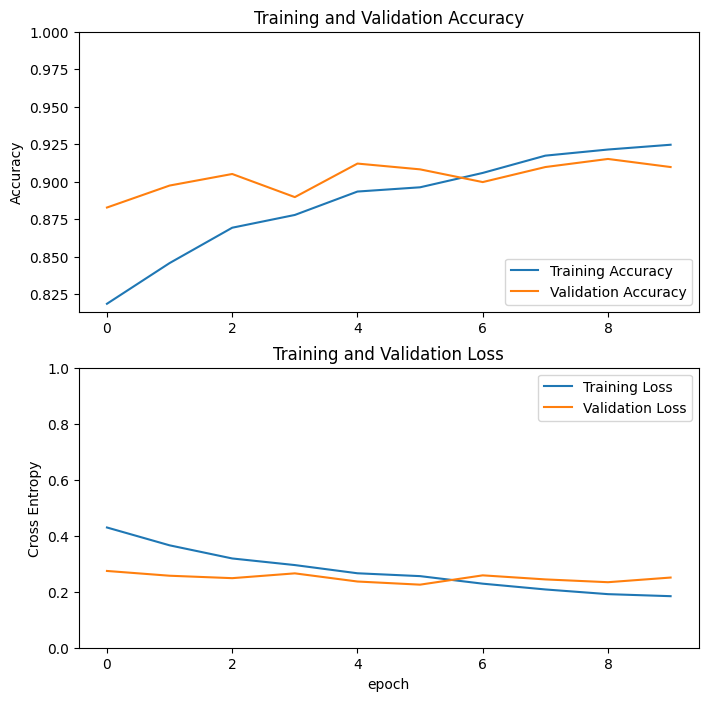

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 2)                 25182210  
                                                                 
Total params: 46984994 (179.23 MB)
Trainable params: 25182210 (96.06 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [ ]:
# No of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  311


In [ ]:
# Define grid search parameters for fine-tuning layers
fine_tune_layers= [200,150,100,50]

In [ ]:
# Perform grid search for fine-tuning layers
results = []
for fine_tune_at in fine_tune_layers:
    print("-----------------------------------------------------")
    print("Freeze the layers before layer:", fine_tune_at)
    base_model.trainable = True

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])

    print("Trainable parameters:",trainable_params)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10,weight_decay=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


    fine_tune_epochs = 10
    total_epochs =  initial_epochs + fine_tune_epochs

    # Define early stopping criteria
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history_fine = model.fit(train_generator, epochs=total_epochs, initial_epoch=history.epoch[-1],validation_data=val_generator,callbacks=[early_stopping])

    loss, accuracy = model.evaluate(test_generator)
    print('Test accuracy of',no_of_fine_tune_layer,"is : ", str(accuracy))

    # Define the file path where you want to save the model
    model_save_path =  "drive/MyDrive/NewLungData/tenserflowModels/inceptionv3_fn_"+str(no_of_fine_tune_layer)

    # Save the entire model to a single HDF5 file
    model.save(model_save_path)

-----------------------------------------------------
No Of Fine-tuning layers: 200
Trainable parameters: 39986498
Epoch 10/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


177/177 [==============================] - 45s 144ms/step - loss: 0.3592 - accuracy: 0.8607 - val_loss: 0.2517 - val_accuracy: 0.9044
Epoch 11/20
177/177 [==============================] - 22s 122ms/step - loss: 0.1648 - accuracy: 0.9374 - val_loss: 0.2272 - val_accuracy: 0.9221
Epoch 12/20
177/177 [==============================] - 21s 116ms/step - loss: 0.0790 - accuracy: 0.9725 - val_loss: 0.2235 - val_accuracy: 0.9306
Epoch 13/20
177/177 [==============================] - 21s 119ms/step - loss: 0.0409 - accuracy: 0.9878 - val_loss: 0.2415 - val_accuracy: 0.9322
Epoch 14/20
177/177 [==============================] - 21s 119ms/step - loss: 0.0284 - accuracy: 0.9918 - val_loss: 0.2597 - val_accuracy: 0.9360
Epoch 15/20
177/177 [==============================] - 21s 118ms/step - loss: 0.0131 - accuracy: 0.9973 - val_loss: 0.2684 - val_accuracy: 0.9352
Epoch 16/20
177/177 [==============================] - 21s 118ms/step - loss: 0.0127 - accuracy: 0.9961 - val_loss: 0.3015 - val_accurac

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


177/177 [==============================] - 41s 131ms/step - loss: 0.2539 - accuracy: 0.9018 - val_loss: 0.1985 - val_accuracy: 0.9322
Epoch 11/20
177/177 [==============================] - 22s 123ms/step - loss: 0.0974 - accuracy: 0.9658 - val_loss: 0.1984 - val_accuracy: 0.9429
Epoch 12/20
177/177 [==============================] - 21s 121ms/step - loss: 0.0395 - accuracy: 0.9869 - val_loss: 0.1981 - val_accuracy: 0.9468
Epoch 13/20
177/177 [==============================] - 21s 120ms/step - loss: 0.0223 - accuracy: 0.9952 - val_loss: 0.2147 - val_accuracy: 0.9375
Epoch 14/20
177/177 [==============================] - 21s 117ms/step - loss: 0.0149 - accuracy: 0.9961 - val_loss: 0.2276 - val_accuracy: 0.9422
Epoch 15/20
177/177 [==============================] - 22s 123ms/step - loss: 0.0107 - accuracy: 0.9968 - val_loss: 0.2430 - val_accuracy: 0.9460
Epoch 16/20
177/177 [==============================] - 22s 123ms/step - loss: 0.0096 - accuracy: 0.9968 - val_loss: 0.2496 - val_accurac

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


177/177 [==============================] - 45s 131ms/step - loss: 0.2387 - accuracy: 0.9087 - val_loss: 0.2065 - val_accuracy: 0.9268
Epoch 11/20
177/177 [==============================] - 22s 123ms/step - loss: 0.0822 - accuracy: 0.9697 - val_loss: 0.1887 - val_accuracy: 0.9406
Epoch 12/20
177/177 [==============================] - 22s 122ms/step - loss: 0.0399 - accuracy: 0.9878 - val_loss: 0.2065 - val_accuracy: 0.9375
Epoch 13/20
177/177 [==============================] - 21s 120ms/step - loss: 0.0255 - accuracy: 0.9924 - val_loss: 0.2154 - val_accuracy: 0.9368
Epoch 14/20
177/177 [==============================] - 22s 123ms/step - loss: 0.0196 - accuracy: 0.9945 - val_loss: 0.2190 - val_accuracy: 0.9391
Epoch 15/20
177/177 [==============================] - 21s 121ms/step - loss: 0.0159 - accuracy: 0.9947 - val_loss: 0.2159 - val_accuracy: 0.9383
Epoch 16/20
51/51 [==============================] - 5s 98ms/step - loss: 0.2615 - accuracy: 0.9137
Test accuracy of 100 is :  0.9136868

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


177/177 [==============================] - 50s 137ms/step - loss: 0.2607 - accuracy: 0.9011 - val_loss: 0.2065 - val_accuracy: 0.9198
Epoch 11/20
177/177 [==============================] - 22s 121ms/step - loss: 0.0902 - accuracy: 0.9663 - val_loss: 0.1871 - val_accuracy: 0.9291
Epoch 12/20
177/177 [==============================] - 21s 120ms/step - loss: 0.0381 - accuracy: 0.9885 - val_loss: 0.1846 - val_accuracy: 0.9429
Epoch 13/20
177/177 [==============================] - 22s 125ms/step - loss: 0.0237 - accuracy: 0.9934 - val_loss: 0.1917 - val_accuracy: 0.9460
Epoch 14/20
177/177 [==============================] - 22s 124ms/step - loss: 0.0179 - accuracy: 0.9943 - val_loss: 0.2012 - val_accuracy: 0.9414
Epoch 15/20
177/177 [==============================] - 21s 120ms/step - loss: 0.0151 - accuracy: 0.9954 - val_loss: 0.2112 - val_accuracy: 0.9406
Epoch 16/20
177/177 [==============================] - 22s 123ms/step - loss: 0.0145 - accuracy: 0.9949 - val_loss: 0.2179 - val_accurac